In [ ]:
# 1. 기존 Pillow 삭제 및 안정적인 버전(9.5.0) 재설치
!pip uninstall -y Pillow
!pip install Pillow==9.5.0

Found existing installation: Pillow 9.5.0
Uninstalling Pillow-9.5.0:
  Successfully uninstalled Pillow-9.5.0
  Using cached Pillow-9.5.0-cp312-cp312-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


In [ ]:
# @title 1. 라이브러리 설치 (simple-lama-inpainting)
# 올바른 패키지 이름으로 설치합니다.
!pip install simple-lama-inpainting ultralytics -q
!pip install segmentation-models-pytorch transformers -q

import os
import glob
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO

# [핵심] 선생님 파일에 있던 정확한 라이브러리 호출
from simple_lama_inpainting import SimpleLama

# GPU 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device}")

✅ Using device: cuda


✅ Device: cuda
⚖️ 가중치 설정 -> Ours: 0.051, SegFormer: 0.949
⏳ (1/2) Custom(Structural Ensemble) 모델 로드 중...
✅ Custom Structural Ensemble 로드 완료!
   alpha = 0.505
⏳ (2/2) SegFormer 모델 로드 중...
✅ SegFormer 로드 완료!
🚀 총 268장의 이미지 분석 시작...


100%|██████████| 268/268 [00:18<00:00, 14.25it/s]



🏆 [앙상블 모델 최종 성능 평가]
✅ Mean IoU: 0.7944


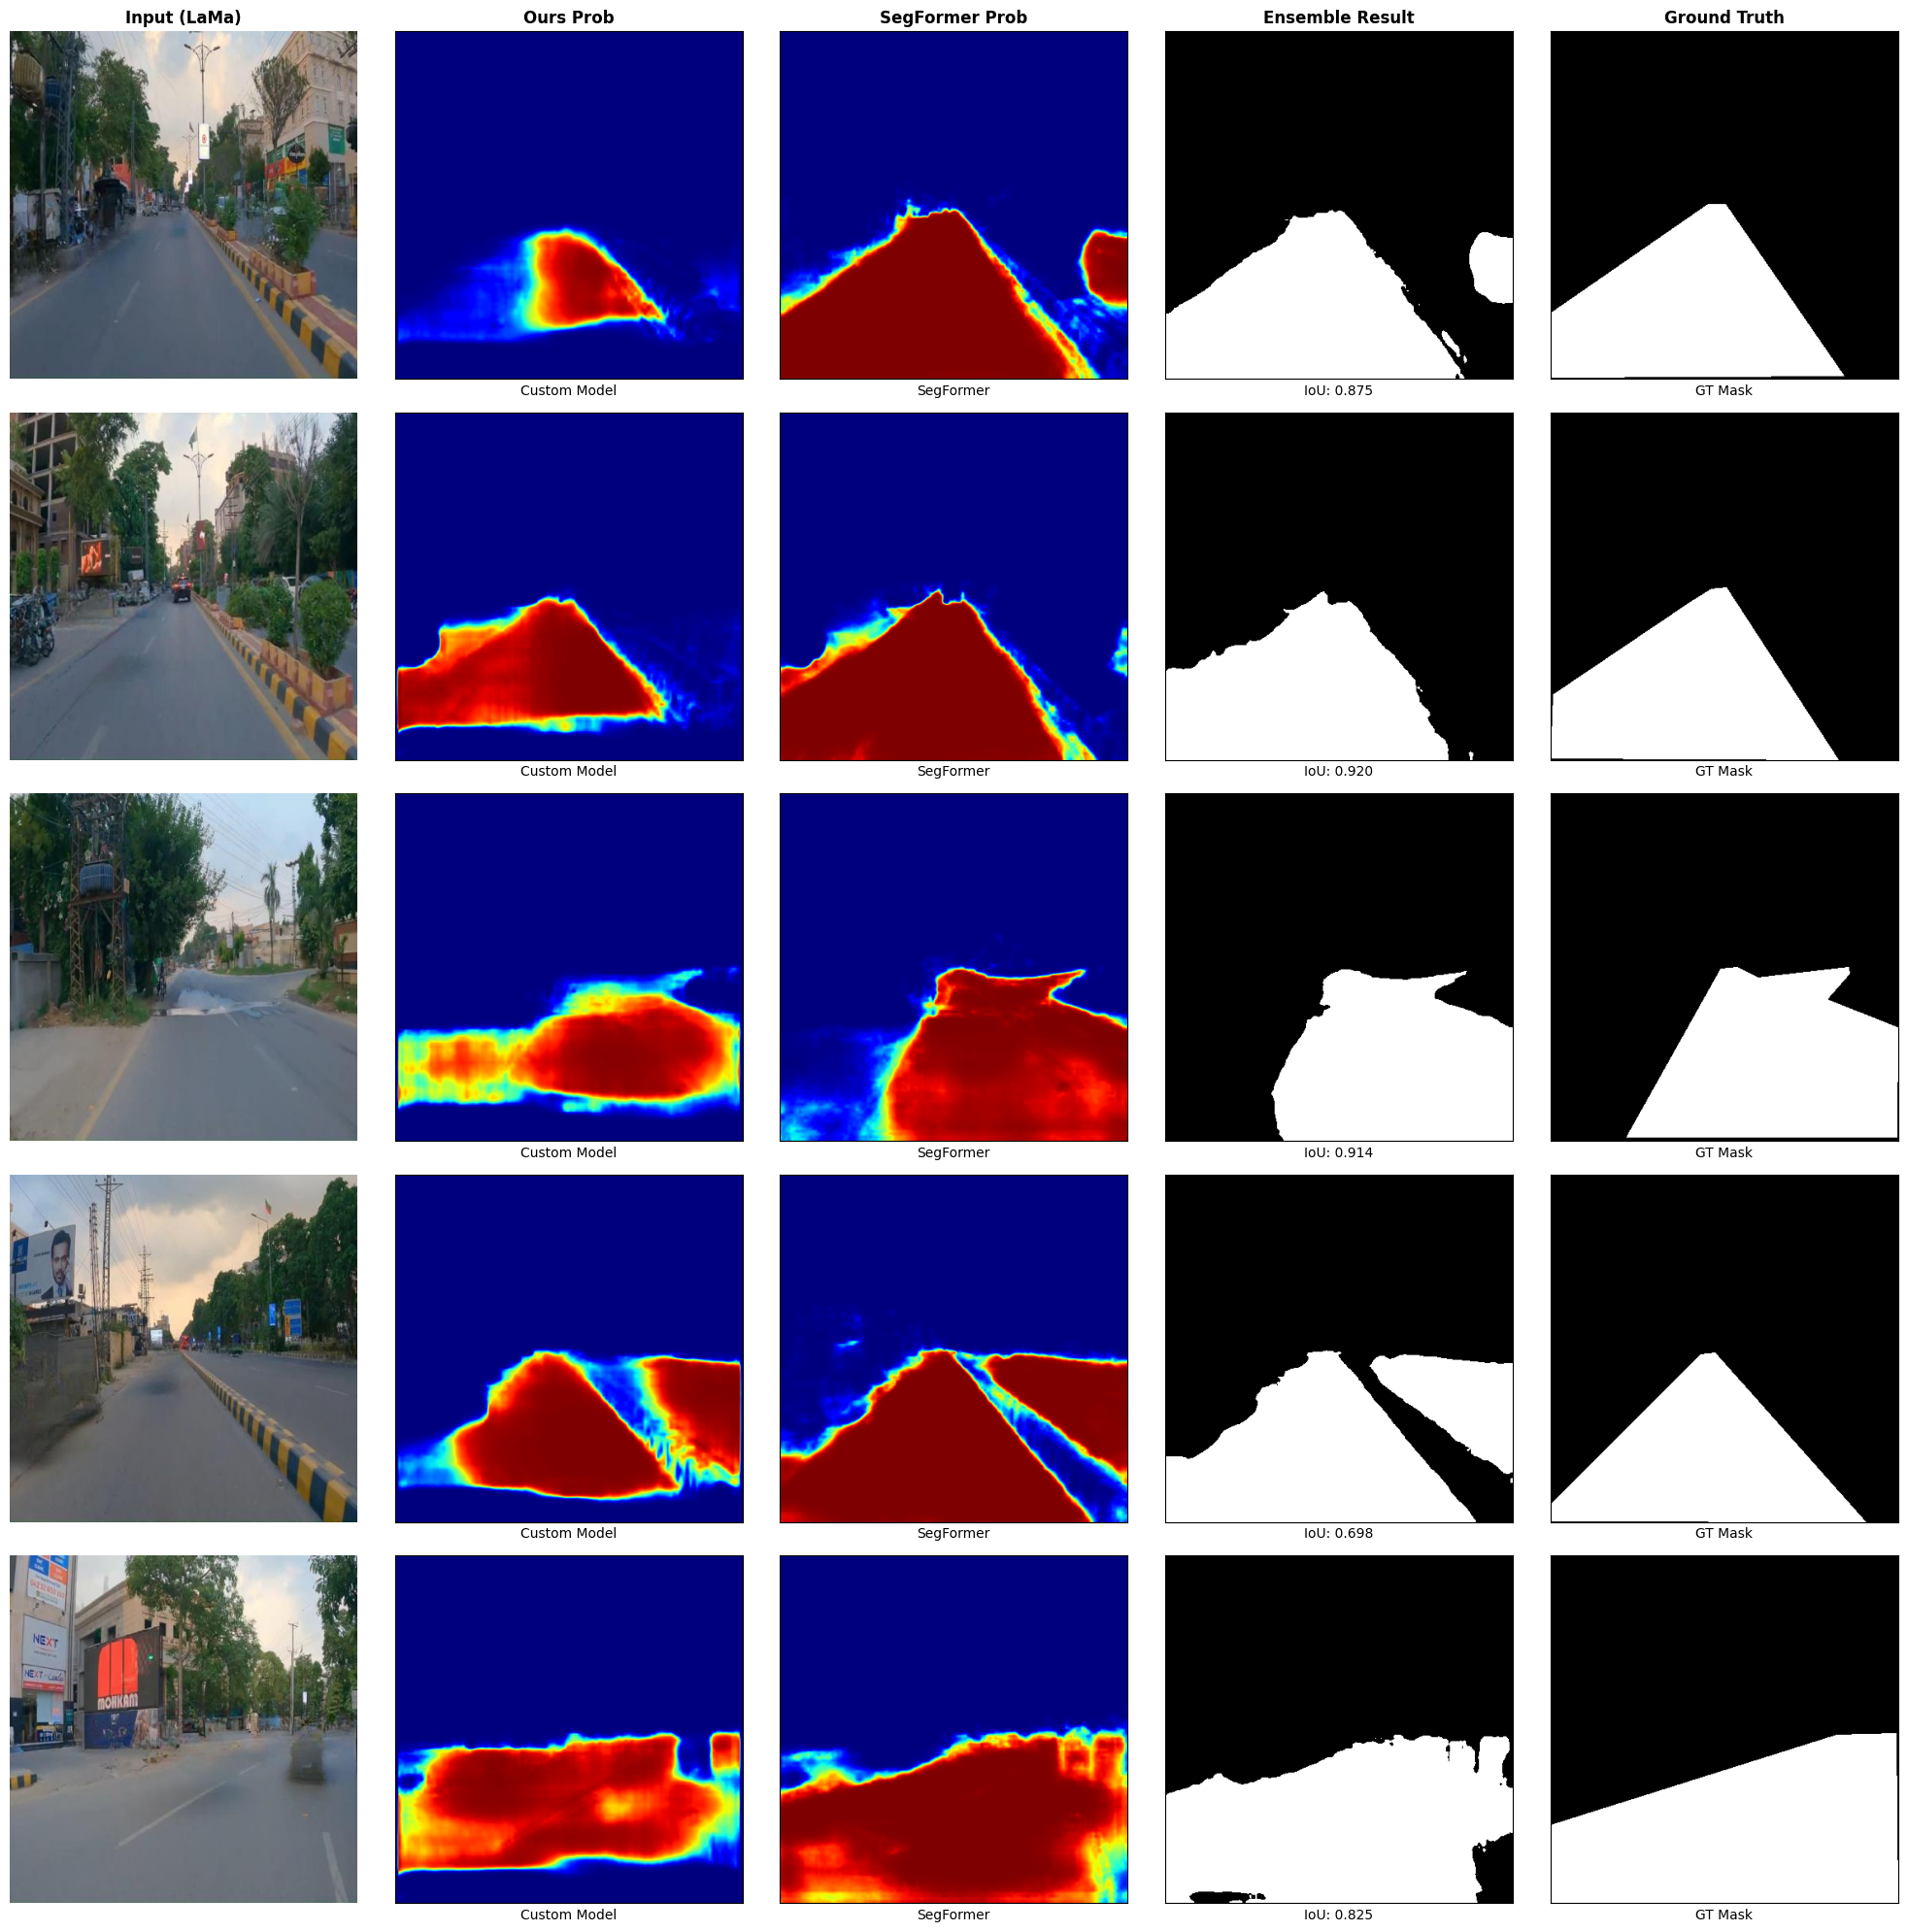

In [ ]:
# @title 🛣️ 앙상블(Ensemble) 세그멘테이션 실행 코드

import os
import json
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torch import nn
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import segmentation_models_pytorch as smp

# ==========================================
# 1. 경로 및 설정 (사용자 지정)
# ==========================================
# Inpainting된 이미지를 Input으로 사용합니다 (성능 극대화)
lama_img_dir = "/content/drive/MyDrive/loid_cityscapes/Road_Dataset/Road-detection-1/train_simple_lama_inpainting"
orig_img_dir = "/content/drive/MyDrive/loid_cityscapes/Road_Dataset/Road-detection-1/train"
json_path = "/content/drive/MyDrive/loid_cityscapes/Road_Dataset/Road-detection-1/train/_annotations.coco.json"
model_path = "/content/drive/MyDrive/loid_cityscapes/experiments/ckpts/ensemble_res34_effb3.pth"

# ⚙️ 앙상블 파라미터 (조절 가능)
WEIGHT_OURS = 0.051
WEIGHT_SEGFORMER = 0.949
FINAL_THRESHOLD = 0.698

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Device: {device}")
print(f"⚖️ 가중치 설정 -> Ours: {WEIGHT_OURS}, SegFormer: {WEIGHT_SEGFORMER}")

# ==========================================
# 2. 모델 1: Ours (DeepLabV3+ ResNet34) 로드
# ==========================================
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import albumentations as A
import segmentation_models_pytorch as smp

# =========================
# 0) Ours inference transform (학습 때 val_tfms와 동일 컨셉)
# =========================
ours_tfms = A.Compose([
    A.Resize(512, 1024),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

def preprocess_ours(image_pil, device):
    """PIL -> (1,3,512,1024) float tensor (normalized)"""
    img = np.asarray(image_pil, dtype=np.uint8)  # HWC uint8
    img = ours_tfms(image=img)["image"]          # HWC float32 normalized
    x = torch.from_numpy(img.transpose(2,0,1)).unsqueeze(0).float().to(device)
    return x

# =========================
# 1) 학습 때와 동일한 모델 정의
# =========================
class LaneSegmentationModel(nn.Module):
    def __init__(self, num_classes=1, encoder="resnet34"):
        super().__init__()
        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder,
            encoder_weights=None,   # 로드로 덮어쓸 거라 None 권장
            classes=num_classes,
            activation=None
        )
    def forward(self, x):
        return self.model(x).squeeze(1)  # [B,H,W] logits

class LogitEnsembleLaneSeg(nn.Module):
    def __init__(self, encoder_a="resnet34", encoder_b="timm-efficientnet-b3"):
        super().__init__()
        self.m1 = LaneSegmentationModel(num_classes=1, encoder=encoder_a)
        self.m2 = LaneSegmentationModel(num_classes=1, encoder=encoder_b)
        self.alpha_logit = nn.Parameter(torch.tensor(0.0))
    def forward(self, x):
        l1 = self.m1(x)
        l2 = self.m2(x)
        a = torch.sigmoid(self.alpha_logit)
        return a * l1 + (1.0 - a) * l2

# =========================
# 2) 체크포인트 로드 (구조적 앙상블로!)
# =========================
print("⏳ (1/2) Custom(Structural Ensemble) 모델 로드 중...")

model_ours = LogitEnsembleLaneSeg(
    encoder_a="resnet34",
    encoder_b="timm-efficientnet-b3"
).to(device)

ckpt = torch.load(model_path, map_location=device)
state_dict = ckpt.get("state_dict", ckpt.get("model_state_dict", ckpt))
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

model_ours.load_state_dict(state_dict, strict=True)
model_ours.eval()

print("✅ Custom Structural Ensemble 로드 완료!")
print(f"   alpha = {torch.sigmoid(model_ours.alpha_logit).item():.3f}")

# =========================
# 3) Ours prob 함수 (원본 해상도로 업샘플까지)
# =========================
@torch.no_grad()
def get_prob_ours(image_pil):
    orig_w, orig_h = image_pil.size

    x = preprocess_ours(image_pil, device)     # [1,3,512,1024]
    logits_small = model_ours(x)               # [1,512,1024]
    prob_small = torch.sigmoid(logits_small).unsqueeze(1)  # [1,1,512,1024]

    prob = F.interpolate(
        prob_small,
        size=(orig_h, orig_w),
        mode="bilinear",
        align_corners=False
    ).squeeze().cpu().numpy()  # [H,W]

    return prob


# ==========================================
# 3. 모델 2: SegFormer 로드
# ==========================================
print("⏳ (2/2) SegFormer 모델 로드 중...")
SEG_NAME = "nvidia/segformer-b0-finetuned-cityscapes-1024-1024"
processor_seg = SegformerImageProcessor.from_pretrained(SEG_NAME)
model_seg = SegformerForSemanticSegmentation.from_pretrained(SEG_NAME).to(device)
model_seg.eval()
print("✅ SegFormer 로드 완료!")

# ==========================================
# 4. 예측 함수 (확률맵 추출)
# ==========================================
def get_prob_ours(image_pil):
    """Custom 모델: 단순 /255.0 스케일링 후 Sigmoid"""
    img_np = np.array(image_pil)
    # BGR check (PIL is RGB, OpenCV is BGR. smp/cv2 pipeline mixed)
    # PIL로 열었으므로 RGB 상태. 하지만 학습때 cv2.imread(BGR) -> RGB 변환했는지 확인 필요.
    # 보통 학습코드에서 cv2.cvtColor(BGR2RGB)를 썼다면 RGB가 맞음.

    img_input = img_np.astype('float32') / 255.0
    img_tensor = torch.from_numpy(img_input.transpose(2, 0, 1)).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model_ours(img_tensor)
        probs = torch.sigmoid(logits)
    return probs.squeeze().cpu().numpy()

def get_prob_segformer(image_pil):
    """SegFormer: 전용 Processor 후 Softmax"""
    inputs = processor_seg(images=image_pil, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_seg(**inputs)

    upsampled_logits = nn.functional.interpolate(
        outputs.logits,
        size=image_pil.size[::-1], # (H, W)
        mode="bilinear", align_corners=False
    )
    probs = upsampled_logits.softmax(dim=1)
    # Class 0 = Road
    return probs[0, 0, :, :].cpu().numpy()

# GT 생성 함수
def create_mask_from_coco(img_info, annotations):
    h, w = img_info['height'], img_info['width']
    mask = np.zeros((h, w), dtype=np.uint8)
    for ann in annotations:
        if 'segmentation' in ann:
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape((-1, 2)).astype(np.int32)
                cv2.fillPoly(mask, [poly], 1)
    return mask

def calculate_iou(pred, gt):
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return inter / union if union > 0 else 0.0

# ==========================================
# 5. 메인 실행 루프
# ==========================================
with open(json_path, 'r') as f:
    coco_data = json.load(f)

img_to_anns = {}
for ann in coco_data['annotations']:
    img_id = ann['image_id']
    if img_id not in img_to_anns: img_to_anns[img_id] = []
    img_to_anns[img_id].append(ann)

results = []
vis_samples = []

print(f"🚀 총 {len(coco_data['images'])}장의 이미지 분석 시작...")

for img_info in tqdm(coco_data['images']):
    file_name = img_info['file_name']
    img_id = img_info['id']

    # 입력 이미지 경로 (LaMa 이미지 사용)
    # 만약 LaMa 이미지가 없으면 원본 사용하도록 예외처리
    input_path = os.path.join(lama_img_dir, file_name)
    if not os.path.exists(input_path):
        input_path = os.path.join(orig_img_dir, file_name)

    if not os.path.exists(input_path): continue

    # 1. 이미지 로드
    image = Image.open(input_path).convert("RGB")

    # 2. GT 로드
    annotations = img_to_anns.get(img_id, [])
    gt_mask = create_mask_from_coco(img_info, annotations)

    # 3. 모델별 예측 (확률맵)
    p_ours = get_prob_ours(image)
    p_seg = get_prob_segformer(image)

    # 4. [앙상블] 가중 합산
    p_ensemble = (p_ours * WEIGHT_OURS) + (p_seg * WEIGHT_SEGFORMER)

    # 5. 최종 결정 (Threshold)
    pred_final = (p_ensemble > FINAL_THRESHOLD).astype(np.uint8)

    # 6. IoU 계산
    iou_ens = calculate_iou(pred_final, gt_mask)

    results.append({
        "filename": file_name,
        "iou": iou_ens
    })

    # 시각화 샘플 수집 (5개)
    if len(vis_samples) < 5:
        vis_samples.append({
            "img": image,
            "p_ours": p_ours,
            "p_seg": p_seg,
            "p_ens": p_ensemble,
            "pred": pred_final,
            "gt": gt_mask,
            "iou": iou_ens
        })

# ==========================================
# 6. 결과 출력
# ==========================================
if results:
    df = pd.DataFrame(results)
    print("\n" + "="*50)
    print("🏆 [앙상블 모델 최종 성능 평가]")
    print("="*50)
    print(f"✅ Mean IoU: {df['iou'].mean():.4f}")
    print("="*50)

    # 시각화
    rows = len(vis_samples)
    fig, axes = plt.subplots(rows, 5, figsize=(20, 4*rows))
    cols = ["Input (LaMa)", "Ours Prob", "SegFormer Prob", "Ensemble Result", "Ground Truth"]
    if rows == 1: axes = [axes]

    for ax, col in zip(axes[0], cols): ax.set_title(col, fontweight='bold', fontsize=12)

    for i, item in enumerate(vis_samples):
        # Input
        axes[i][0].imshow(item['img'])
        axes[i][0].axis('off')

        # Ours Prob (Heatmap)
        axes[i][1].imshow(item['p_ours'], cmap='jet', vmin=0, vmax=1)
        axes[i][1].set_xlabel("Custom Model")
        axes[i][1].set_xticks([]); axes[i][1].set_yticks([])

        # SegFormer Prob (Heatmap)
        axes[i][2].imshow(item['p_seg'], cmap='jet', vmin=0, vmax=1)
        axes[i][2].set_xlabel("SegFormer")
        axes[i][2].set_xticks([]); axes[i][2].set_yticks([])

        # Ensemble Result (Binary)
        axes[i][3].imshow(item['pred'], cmap='gray')
        axes[i][3].set_xlabel(f"IoU: {item['iou']:.3f}")
        axes[i][3].set_xticks([]); axes[i][3].set_yticks([])

        # GT
        axes[i][4].imshow(item['gt'], cmap='gray')
        axes[i][4].set_xlabel("GT Mask")
        axes[i][4].set_xticks([]); axes[i][4].set_yticks([])

    plt.tight_layout()
    plt.show()
else:
    print("❌ 처리할 이미지가 없습니다.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from tqdm import tqdm
import heapq

EPS = 1e-7

def _iou_from_bool(pred_bool, gt_bool):
    inter = np.logical_and(pred_bool, gt_bool).sum()
    union = np.logical_or(pred_bool, gt_bool).sum()
    return float(inter / (union + EPS))

def mean_iou_fast(p_ours_list, p_seg_list, gt_list, w, thr,
                  idxs=None, pix_indices=None):
    """
    - idxs: 사용할 이미지 인덱스 리스트(서브셋 평가용)
    - pix_indices: 이미지별로 사용할 픽셀 인덱스(근사 평가용). None이면 전체 픽셀
    """
    if idxs is None:
        idxs = range(len(gt_list))

    ious = []
    w = np.float32(w)
    thr = np.float32(thr)

    for i in idxs:
        gt = gt_list[i]
        p_ours = p_ours_list[i]
        p_seg  = p_seg_list[i]

        if pix_indices is not None and pix_indices[i] is not None:
            ridx = pix_indices[i]
            gt_s = (gt.reshape(-1)[ridx] > 0).astype(bool)

            # p = w*p_ours + (1-w)*p_seg  (샘플된 픽셀만)
            p_ours_s = p_ours.reshape(-1)[ridx].astype(np.float32)
            p_seg_s  = p_seg.reshape(-1)[ridx].astype(np.float32)
            p = w * p_ours_s + (1.0 - w) * p_seg_s
            pred = (p > thr)
            ious.append(_iou_from_bool(pred, gt_s))
        else:
            gt_b = (gt > 0).astype(bool)
            p = (w * p_ours.astype(np.float32) + (1.0 - w) * p_seg.astype(np.float32))
            pred = (p > thr)
            ious.append(_iou_from_bool(pred, gt_b))

    return float(np.mean(ious)) if len(ious) else 0.0


def random_search_weight_threshold(
    p_ours_list, p_seg_list, gt_list,
    n_trials=400,
    w_range=(0.0, 1.0),
    thr_range=(0.30, 0.70),
    subset_size=120,          # 근사 평가에 쓸 이미지 수
    sample_pixels=20000,      # 이미지당 픽셀 샘플 수 (None이면 전체 픽셀)
    top_k=20,                 # 근사 점수 상위 K개만 전체 평가
    seed=0,
    verbose_every=50
):
    rng = np.random.default_rng(seed)
    N = len(gt_list)
    assert N > 0, "gt_list가 비어있음"

    # 1) 이미지 서브셋 선택 (근사 평가용)
    subset_size = min(subset_size, N)
    subset_idxs = rng.choice(N, size=subset_size, replace=False)

    # 2) 픽셀 샘플 인덱스 미리 만들어두기 (trial마다 재샘플링 방지)
    pix_indices = None
    if sample_pixels is not None:
        pix_indices = []
        for gt in gt_list:
            H, W = gt.shape
            M = H * W
            if sample_pixels >= M:
                pix_indices.append(None)  # 전체 픽셀
            else:
                pix_indices.append(rng.integers(0, M, size=sample_pixels, endpoint=False, dtype=np.int64))

    # 상위 후보만 보관 (min-heap)
    heap = []  # (miou_est, w, thr)
    best_est = (-1.0, None, None)

    # 3) Random trials (근사 점수)
    for t in tqdm(range(n_trials), desc="Random Search (approx)"):
        w = rng.uniform(w_range[0], w_range[1])
        thr = rng.uniform(thr_range[0], thr_range[1])

        miou_est = mean_iou_fast(
            p_ours_list, p_seg_list, gt_list,
            w=w, thr=thr,
            idxs=subset_idxs, pix_indices=pix_indices
        )

        if miou_est > best_est[0]:
            best_est = (miou_est, float(w), float(thr))

        if len(heap) < top_k:
            heapq.heappush(heap, (miou_est, float(w), float(thr)))
        else:
            if miou_est > heap[0][0]:
                heapq.heapreplace(heap, (miou_est, float(w), float(thr)))

        if verbose_every and (t + 1) % verbose_every == 0:
            print(f"[{t+1}/{n_trials}] best_est mIoU={best_est[0]:.4f} (w={best_est[1]:.3f}, thr={best_est[2]:.3f})")

    # 4) 상위 후보를 전체 데이터+전체 픽셀로 재평가 (정확 점수)
    top = sorted(heap, key=lambda x: x[0], reverse=True)

    best_full = (-1.0, None, None)
    for (miou_est, w, thr) in tqdm(top, desc="Re-eval TopK (exact)"):
        miou = mean_iou_fast(
            p_ours_list, p_seg_list, gt_list,
            w=w, thr=thr,
            idxs=None, pix_indices=None  # 전체 정확 평가
        )
        if miou > best_full[0]:
            best_full = (miou, w, thr)

    return {
        "best_exact_miou": best_full[0],
        "best_w": best_full[1],
        "best_thr": best_full[2],
        "best_est_miou": best_est[0],
        "best_est_w": best_est[1],
        "best_est_thr": best_est[2],
        "top_candidates_est": top,
        "subset_idxs_used": subset_idxs
    }


In [ ]:
res = random_search_weight_threshold(
    p_ours_list, p_seg_list, gt_list,
    n_trials=1000,          # 더 빨리: 200 / 더 정밀: 1000
    w_range=(0.0, 1.0),
    thr_range=(0.30, 0.70),
    subset_size=120,
    sample_pixels=20000,   # GPU/CPU 여유 없으면 10000으로
    top_k=20,
    seed=42,
    verbose_every=50
)

print("\n" + "="*60)
print("🏆 Random Search Result (exact)")
print("="*60)
print(f"✅ Best mIoU:   {res['best_exact_miou']:.4f}")
print(f"✅ ours_w:      {res['best_w']:.3f}")
print(f"✅ seg_w:       {1.0 - res['best_w']:.3f}")
print(f"✅ threshold:   {res['best_thr']:.3f}")
print("="*60)


Random Search (approx):   5%|▌         | 51/1000 [00:08<01:54,  8.29it/s]

[50/1000] best_est mIoU=0.7891 (w=0.023, thr=0.667)


Random Search (approx):  10%|█         | 101/1000 [00:19<01:50,  8.12it/s]

[100/1000] best_est mIoU=0.7895 (w=0.066, thr=0.682)


Random Search (approx):  15%|█▌        | 151/1000 [00:25<01:33,  9.09it/s]

[150/1000] best_est mIoU=0.7895 (w=0.066, thr=0.682)


Random Search (approx):  20%|██        | 201/1000 [00:32<01:31,  8.71it/s]

[200/1000] best_est mIoU=0.7895 (w=0.098, thr=0.699)


Random Search (approx):  25%|██▌       | 251/1000 [00:37<01:21,  9.17it/s]

[250/1000] best_est mIoU=0.7895 (w=0.098, thr=0.699)


Random Search (approx):  30%|███       | 301/1000 [00:44<01:50,  6.34it/s]

[300/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  35%|███▌      | 351/1000 [00:49<01:12,  8.98it/s]

[350/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  40%|████      | 401/1000 [00:55<01:27,  6.87it/s]

[400/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  45%|████▌     | 451/1000 [01:11<01:53,  4.82it/s]

[450/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  50%|█████     | 501/1000 [01:17<00:56,  8.88it/s]

[500/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  55%|█████▌    | 551/1000 [01:22<00:59,  7.53it/s]

[550/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  60%|██████    | 601/1000 [01:29<00:42,  9.46it/s]

[600/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  65%|██████▌   | 651/1000 [01:34<00:37,  9.41it/s]

[650/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  70%|███████   | 701/1000 [01:41<00:32,  9.10it/s]

[700/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  75%|███████▌  | 751/1000 [01:46<00:26,  9.23it/s]

[750/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  80%|████████  | 801/1000 [01:53<00:30,  6.55it/s]

[800/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  85%|████████▌ | 851/1000 [01:59<00:15,  9.37it/s]

[850/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  90%|█████████ | 901/1000 [02:04<00:12,  8.21it/s]

[900/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx):  95%|█████████▌| 951/1000 [02:10<00:05,  9.30it/s]

[950/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Random Search (approx): 100%|██████████| 1000/1000 [02:16<00:00,  7.35it/s]


[1000/1000] best_est mIoU=0.7897 (w=0.062, thr=0.699)


Re-eval TopK (exact): 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


🏆 Random Search Result (exact)
✅ Best mIoU:   0.7944
✅ ours_w:      0.051
✅ seg_w:       0.949
✅ threshold:   0.698
